In [32]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

import scipy.stats

import logging

from datetime import date
import os

## Simulate Data

In [33]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

In [34]:
true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


# np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

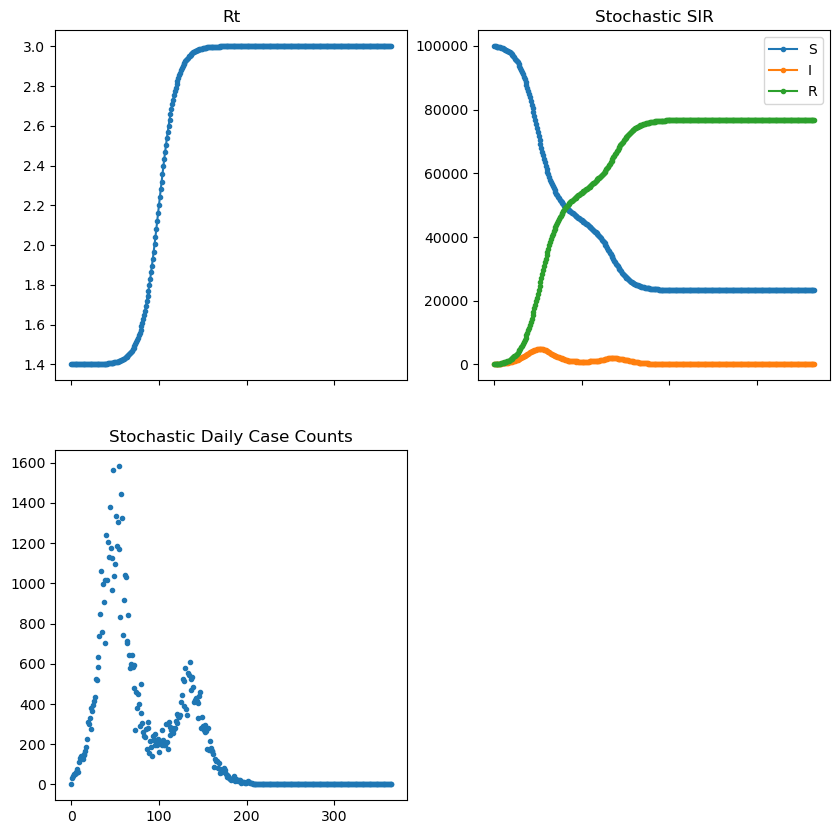

In [35]:
data.plot_all()

## Metropolis Hastings

In [36]:
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [37]:
n_t = 365
t = np.arange(n_t)
t_I = 4.
N = 100_000

In [48]:
def halfcauchy(x,beta):
    if x < 0:
        raise ValueError("x must be positive")
    if beta < 0:
        raise ValueError("beta must be positive")
        
    return 2/(np.pi*beta*(1+(x/beta)**2))

def sample_new(rt_0, rt_1, k, midpoint, I0, scale=5):
    new_draw = multivariate_normal(mean=[rt_0, rt_1, k, midpoint, I0], cov=scale).rvs(1)
    return new_draw[0], new_draw[1], new_draw[2], new_draw[3], new_draw[4]

def sample_new_midpoint(midpoint, scale=1):
    new_draw = norm(loc=midpoint, scale=scale).rvs(1)
    return int(new_draw[0])

def random_coin(p):
    unif = np.random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

def log_random_coin(logp):
    unif = np.random.uniform(0,1)
    if np.log(unif)>=logp:
        return False
    else:
        return True


def integrate(rt_0, rt_1, k, midpoint, I0, t_I, N, S0, n_t):
    t = np.arange(365)
    rt = rt_0 + (rt_1 - rt_0) / (1. + np.exp(-k*(t - midpoint)))
    beta = rt / t_I
    S = np.array([S0])
    Ir = np.array([I0])
    R = np.array([0])
    i = np.array([0])
    for t in range(n_t):
        dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/N)
        dIR = np.random.poisson(Ir[t]/t_I)

        S_new = np.clip(S[t]-dSI, 0, N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, N)
        R_new = np.clip(R[t]+dIR, 0, N)

        S = np.append(S, S_new)
        Ir = np.append(Ir, I_new)
        R = np.append(R, R_new)
        i = np.append(i, dSI)

    return S, Ir, R, i

# def sample_prior():
#     rt_0 = np.random.uniform(1., 4.)
#     rt_1 = np.random.uniform(1.5, 4.)
#     k = np.random.uniform(0.01, 2.)
#     midpoint = np.random.randint(30, 200)
#     I0 = np.random.poisson(50)
    
#     return rt_0, rt_1, k, midpoint, I0


def logprior_prob(rt_0, rt_1, k, midpoint, I0):
    # p_rt_0 = uniform(loc=1., scale=3.).pdf(rt_0)
    # p_rt_1 = uniform(loc=1.5, scale=2.5).pdf(rt_1)
    # p_k = uniform(loc=0.01, scale=1.99).pdf(k)
    p_midpoint = randint(low=30, high=200).logpmf(midpoint)
#     p_I0 = poisson(50).pmf(I0)
    
#     prob = np.prod([p_rt_0, p_rt_1, p_k, p_midpoint, p_I0])
    
    return p_midpoint

def loglike_prob(i, data=data.i):
    prob = multivariate_normal(mean=i[1:], cov=np.diag((1+0.2*i[1:])**2)).logpdf(data[1:])
    # prob = norm(loc=data[100], scale=np.abs(1+0.2*data[100])).pdf(i[100])
    return prob
    
    
def metropolis_hastings(burn_in, draws):
    chain = []
    acceptance_list = []
    accept = []
    
    rt_0 = 1.4
    rt_1 = 3.
    k = 0.1
    midpoint = 90
    I0 = 100
    
    S0 = N - I0
    
    current = {
        "rt_0": rt_0,
        "rt_1": rt_1,
        "k": k,
        "midpoint": midpoint,
        "I0": I0,
    }
    chain.append(current)
    
    from tqdm import tqdm
    
    for i in tqdm(range(burn_in+draws)):
        
        _, _, _, i = integrate(rt_0, rt_1, k, midpoint, I0, t_I, N, S0, n_t)
        
        # rt_0_new, rt_1_new, k_new, midpoint_new, I0_new = sample_new(rt_0, rt_1, k, midpoint, I0)
        midpoint_new = sample_new_midpoint(midpoint)

        _, _, _, i_new = integrate(rt_0, rt_1, k, midpoint_new, I0, t_I, N, S0, n_t)
        
        like = loglike_prob(i)
        prior = logprior_prob(rt_0, rt_1, k, midpoint, I0)
        curr_prob = prior + like
        
        prior_new = logprior_prob(rt_0, rt_1, k, midpoint_new, I0)
        like_new = loglike_prob(i_new)
        move_prob = prior_new + like_new
        
        logacceptance = np.minimum(move_prob - curr_prob, 0.)
        acceptance_list.append(logacceptance)
        if log_random_coin(logacceptance):
            current = {
                "rt_0": rt_0,
                "rt_1": rt_1,
                "k": k,
                "midpoint": midpoint_new,
                "I0": I0,
            }
            # rt_0 = rt_0_new
            # rt_1 = rt_1_new
            # k = k_new
            midpoint = midpoint_new
            # I0 = I0_new
            accept.append(1)
        else:
            accept.append(0)
            
        chain.append(current)
    
    return chain[burn_in:], chain[:burn_in], accept, acceptance_list, i

In [49]:
trace, burn_in, accept, acceptance_list, i = metropolis_hastings(burn_in=100, draws=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.88it/s]


In [50]:
burn_in_df = pd.DataFrame(burn_in)

In [51]:
df = pd.DataFrame(trace)

In [52]:
df.mean()

rt_0          1.400000
rt_1          3.000000
k             0.100000
midpoint     70.831683
I0          100.000000
dtype: float64

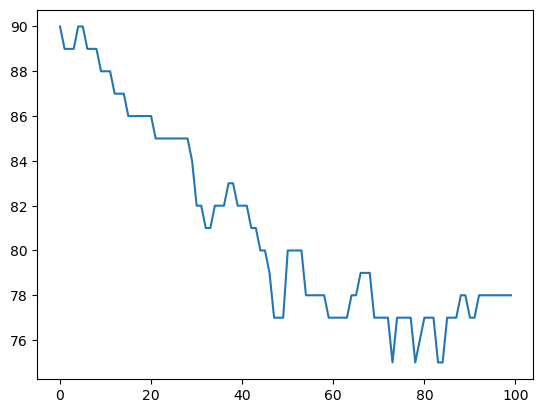

In [53]:
plt.plot(burn_in_df.midpoint)

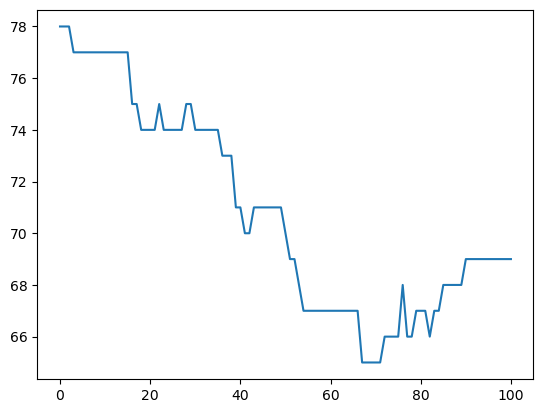

In [54]:
plt.plot(df.midpoint)

<AxesSubplot: ylabel='Frequency'>

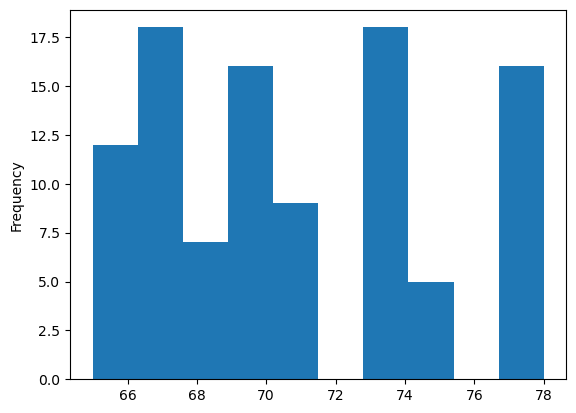

In [55]:
df.midpoint.plot.hist()

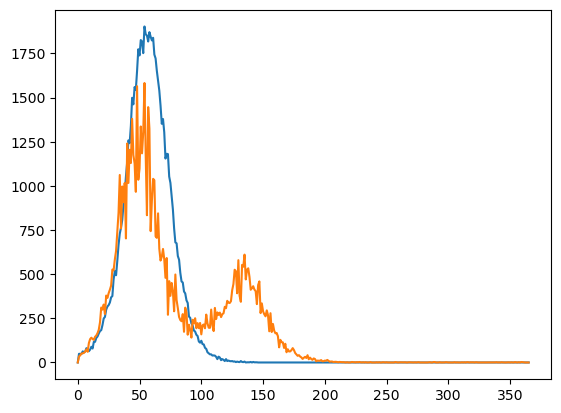

In [56]:
plt.plot(i)
plt.plot(data.i)

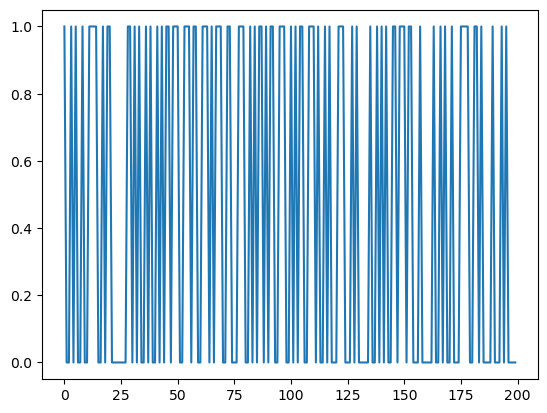

In [58]:
plt.plot(np.exp(acceptance_list))

### Figure out how the hell PyMC is calculating likelihoods

In [25]:


loglike_prob(i)

-790298.5758905652

In [133]:
import pymc as pm
import pytensor
import pytensor.tensor as pt

def compute_loglikelihood(i):
    t = np.arange(0, 365)
    coords = {'day':t}
    with pm.Model(coords=coords) as likelihood_sampler:
        normal = pm.MvNormal(
            "like_normal",
            mu=i[1:],
            cov=np.diag((1+0.2*i[1:])**2),
            dims="day"
        )
    return likelihood_sampler.compile_logp()({'like_normal': data.i[1:]})

In [134]:
compute_loglikelihood(i)

array(-3400296.51916413)

In [135]:
t = np.arange(0, 365)
coords = {'day':t}
with pm.Model(coords=coords) as likelihood_sampler:
    normal = pm.MvNormal(
        "like_normal",
        mu=i[1:],
        cov=np.diag((1+0.2*i[1:])**2),
        dims="day"
    )

In [136]:
pm.logp(normal, data.i[1:]).eval()

array(-3400296.51916413)

Things are consistent between PyMC and my janky code when using `pm.MvNormal`

In [137]:
def like_prob_univariate(i, data=data.i):
    prob = norm(loc=i[1:], scale=(1+0.2*i[1:])).logpdf(data[1:])
    return prob

In [138]:
np.sum(like_prob_univariate(i))

-3400296.5191641324

In [139]:
t = np.arange(0, 365)
coords = {'day':t}
with pm.Model(coords=coords) as likelihood_sampler:
    normal = pm.Normal(
        "like_normal",
        mu=i[1:],
        sigma=np.abs(1+0.2*i[1:]),
        dims="day"
    )

In [140]:
np.sum(pm.logp(normal, data.i[1:]).eval())

-3400296.5191641324